# Analysis of song lyrics

In [1]:
import os
import nltk
import pickle
import string
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, confusion_matrix

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

%matplotlib inline

In [2]:
# Some basic helpers for cleaning up

STOPWORDS = stopwords.words('english') + list(string.punctuation)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [3]:
# File paths to data

data_path = "../Data/"

NJU_data_path = data_path + "NJU_data/"

moods = ["Angry", "Happy", "Relaxed", "Sad"]
y_values = [0, 1, 2, 3]

mood_train = [NJU_data_path + mood + "/Train/" for mood in moods]
mood_test = [NJU_data_path + mood + "/Test/" for mood in moods]

In [4]:
def read_lyrics(path):
    """ Read file and remove timestamps. """
    lyrics = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip().split(']')[-1]
            if len(line) == 0:
                continue
            lyrics.append(line)
    return lyrics

def stem_lyrics(lyrics):
    """
    Remove punctuation, cast to lowercase and stem words.
    Remove stopwords.
    """
    stemmed_lyrics = []
    for line in lyrics:
        line = line.translate(line.maketrans("", "", string.punctuation))
        words = []
        for word in word_tokenize(line):
            word = word.lower()
            word = stemmer.stem(word)
    #         word = lemmatizer.lemmatize(word)
            try:
                tmp = int(word)
                continue
            except:
                if word not in STOPWORDS:
                    words.append(word)
        newline = " ".join(words)
        stemmed_lyrics.append(newline)
    return stemmed_lyrics

https://www.nltk.org/book/ch06.html

### Load data

In [5]:
raw_documents = []
y_train = []
for idx, train_folder in enumerate(mood_train):
    for fname in os.listdir(train_folder):
        if fname == "info.txt":
            continue
        lyrics = stem_lyrics(read_lyrics(train_folder + fname))
        doc = " ".join(lyrics)
        raw_documents.append(doc)
        y_train.append(idx)

In [6]:
no_features = 500

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(raw_documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
word_dictionary = set(tfidf_feature_names)

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(raw_documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [7]:
X, y = shuffle(tfidf, np.array(y_train))
X = X.toarray()

In [8]:
test_documents = []
y_test = []

for idx, test_folder in enumerate(mood_test):
    for fname in os.listdir(test_folder):
        if fname == "info.txt":
            continue
        lyrics = stem_lyrics(read_lyrics(test_folder + fname))
        doc = " ".join(lyrics)
        test_documents.append(doc)
        y_test.append(idx)
        
test_tfidf = tfidf_vectorizer.transform(test_documents)
X_test = test_tfidf.toarray()
y_test = np.array(y_test)

### Training classifiers

In [9]:
baes = GaussianNB()
baes = baes.fit(X, y)
baes_train_acc = baes.score(X, y)
baes_test_acc = baes.score(X_test, y_test)

print("Naive Bayes")
print("Train acc: {:.2f} %".format(baes_train_acc * 100))
print("Test acc: {:.2f} %".format(baes_test_acc * 100))

Naive Bayes
Train acc: 88.25 %
Test acc: 38.73 %


In [10]:
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
lr = lr.fit(X, y)
lr_train_acc = lr.score(X, y)
lr_test_acc = lr.score(X_test, y_test)

print("Logistic Regression")
print("Train acc: {:.2f} %".format(lr_train_acc * 100))
print("Test acc: {:.2f} %".format(lr_test_acc * 100))

Logistic Regression
Train acc: 92.50 %
Test acc: 40.85 %


In [11]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf.fit(X, y)
rf_train_acc = rf.score(X, y)
rf_test_acc = rf.score(X_test, y_test)

print("Random Forests")
print("Train acc: {:.2f} %".format(rf_train_acc * 100))
print("Test acc: {:.2f} %".format(rf_test_acc * 100))

Random Forests
Train acc: 74.50 %
Test acc: 40.85 %


Combine these three classifiers and create a voting method. Use their training and test accuracies to weight their votes. Test accuracies get higher weightage. Then, we train on the entire data (test + train).

In [12]:
# First we get the weights
train_acc = np.array([baes_train_acc, lr_train_acc, rf_train_acc])
test_acc  = np.array([baes_test_acc, lr_test_acc, rf_test_acc])

train_wts = train_acc / np.sum(train_acc)
test_wts = test_acc / np.sum(test_acc)

weights = train_wts + 2*test_wts
weights = weights / np.sum(weights)

# Now, create a voting classifier
committee = VotingClassifier(estimators=[('Baes', baes), ('LogReg', lr), ('RandForests', rf)],
                             voting='soft',
                             weights=weights)

all_X = np.concatenate((X, X_test), axis=0)
all_y = np.concatenate((y, y_test), axis=0)

cv_scores = cross_val_score(committee, all_X, all_y, cv=10)
avg_score = np.mean(cv_scores)
print("10-fold cross validation score: {:.2f} %".format(avg_score*100))

# Now fit and pickle model
committee = committee.fit(all_X, all_y)
with open("models/committee.pkl", "wb") as f:
    pickle.dump(committee, f)

10-fold cross validation score: 36.40 %


Confusion matrix

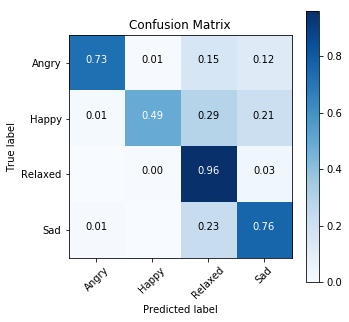

In [13]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Blues,
                          x=5, verbose=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if verbose:
            print("Normalized confusion matrix")
            print(cm)
    else:
        if verbose:
            print('Confusion matrix, without normalization')
            print(cm)
    
    plt.figure(figsize=(x, x))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] == 0:
            continue
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#     plt.savefig("conf_mat-perfect.png", bbox_inches = "tight", dpi=200)
    
    plt.show()

y_pred = committee.predict(all_X)
C = confusion_matrix(all_y, y_pred, labels=y_values)
plot_confusion_matrix(C, classes=moods, cmap=plt.cm.Blues, x=5, title="Confusion Matrix")

#### Topic Modeling

In [14]:
no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [15]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(nmf, list(word_dictionary), no_top_words)

print("\n...\n")

no_top_words = 20
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
wed thought insid peac train imagin wall warm fight answer hour easi follow laugh said kiss weve away late flow
Topic 1:
angel shit reach burn wall alway glad shot drop warm play sky dead weve gave littl youv breath dream gone
Topic 2:
lose die burn shadi shot quit slowli fight melt forev easi insid broken flow answer hurt wrong scare sick listen
Topic 3:
cross drown touch hate imagin snow answer aint friend melt doubt hold empti scare everybodi hide peac wouldnt buy die
Topic 4:
babi earth boy slowli lucki girl clear step worri perfect let imagin damn pay blow man best death hit tonight

...

Topic 0:
life secret cri dont oh world live need know thi im love ive die care dream sun whoa want hold
Topic 1:
heart gave thi christma im someon come year mayb know break dont bird save tear veri day away hear ladi
Topic 2:
im hey thi burn look alright dont wa chang fuck dead shadi whi home kill danc shit war everybodi got
Topic 3:
la make life wonder imagin goe uh love hear master lor